 # Starting from the tCCA projections of Writhe and Distances at the same lag

In [1]:
import mdtraj as md
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from importlib import reload
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from cycler import cycler
from importlib import reload
# source modules and classes being developed 
import package
from package.writhe.writhe import Writhe
from package import visualize
from package.utils import utils
from package import mdtool
from package.msmtool.msmtool import (tCCA, vamp2, MarkovModel,
                                     Kmeans, microstate_indices,
                                     cluster_similarity, transition_network)

from utils.utils import (lsdir, group_by,
                         indices_stat, sort_by_val_in,
                         reindex_list, sort_indices_list,
                         count_int_arr)

#voro calculation
neigh = package.mdtool.Neighbors(cubic_box_length=float(trj.unitcell_lengths[0,0]),
                                 xyz = slice_traj(trj, "protein and not type H").xyz)
selection = [trj.top.select(f" resid {i} and not type H") for i in range(trj.n_residues)]
voro = neigh.voro(np.arange(trj.n_frames), selection)
counts = np.fromiter(map(len, selection), int)
norm = voro.shape[-1] / (trj.unitcell_lengths[0,0]**3 * counts)
vnorm = voro * norm

In [2]:
data_dir = "/home/t/writhe/actr/data"
msm_dir = "/home/t/writhe/actr/msm"
obs_dir = data_dir+"/observables"
protein_name = "ACTR"
Distances = mdtool.ResidueDistances.load(lsdir(data_dir, ["dict", "distance"])[0])
obs = utils.load_array_dir(obs_dir)
writhe_tcca = np.load(f"{lsdir(data_dir, 'tcca')[0]}")
writhe_files = lsdir(data_dir+"/writhe", "dict")

/home/t/writhe/Writhe_Package/package/utils/utils.py:127: UserWarning: Not all strings contain a number, returning unsorted input list to avoid throwing an error. If you want to only consider strings that contain a digit, set indexed to True 
  warnings.warn("Not all strings contain a number, returning unsorted input list to avoid throwing an error. "
/home/t/writhe/Writhe_Package/package/utils/utils.py:127: UserWarning: Not all strings contain a number, returning unsorted input list to avoid throwing an error. If you want to only consider strings that contain a digit, set indexed to True 
  warnings.warn("Not all strings contain a number, returning unsorted input list to avoid throwing an error. "


In [7]:
dist_tcca = tCCA(Distances.distances, 10, 5)
distance_tcca = dist_tcca.fit_transform()

Text(0.48, 1, 'ACTR')

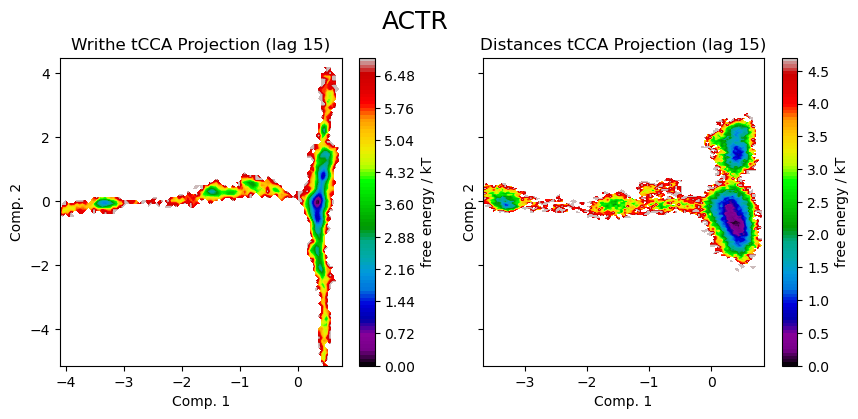

In [9]:
import pyemma
fig,axes=plt.subplots(1,2, sharey=True,figsize=(10,4))
for ax,name,data in zip(axes.flat, 
                        "Writhe,Distances".split(","),
                        [writhe_tcca, distance_tcca],
                       ):
    
    ax.set_xlabel("Comp. 1")
    ax.set_ylabel("Comp. 2")
    ax.set_title(f"{name} tCCA Projection (lag 15)")
    pyemma.plots.plot_free_energy(*data[:,:2].T,ax=ax )
fig.suptitle(protein_name, fontsize=18, y=1,x=.48)

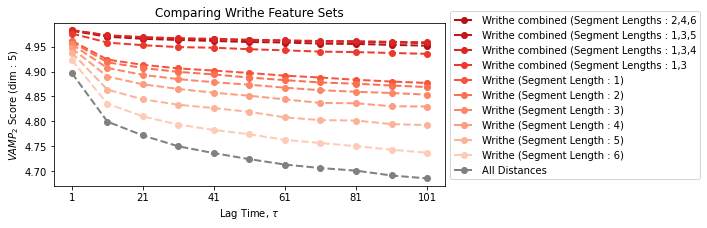

In [8]:
srv_proj = np.load("/home/t/writhe/actr/srv/projs.best.npy")
srv_score = vamp2(srv_proj, 15)

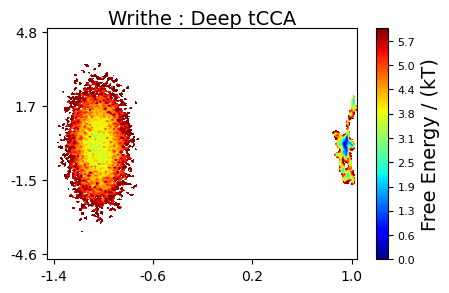

In [13]:
visualize.fes2d(srv_proj[:,:2], title = "Writhe : Deep tCCA")

 # Cluster projections

n_clusters = 40
proj_dim = 4
msm_lag = 8
test_lag = 5
dtraj, frames_cl = Kmeans(writhe_tcca, n_clusters, proj_dim)
dist_dtraj, dist_frames_cl = Kmeans(distance_tcca, n_clusters, proj_dim)
dist_msm = MarkovModel(dist_dtraj).estimate_msm(lag=test_lag, steps= 16)
msm=MarkovModel(msm.dtraj).estimate_msm(lag=test_lag, steps=16)

In [10]:
#restore_msms
dist_msm, msm = [MarkovModel.load(file) for file in lsdir(msm_dir, exclude="long")]

/home/t/writhe/Writhe_Package/package/utils/utils.py:127: UserWarning: Not all strings contain a number, returning unsorted input list to avoid throwing an error. If you want to only consider strings that contain a digit, set indexed to True 
  warnings.warn("Not all strings contain a number, returning unsorted input list to avoid throwing an error. "


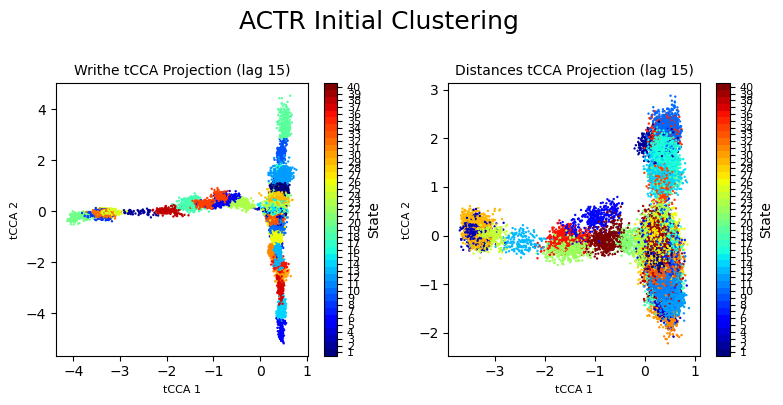

In [11]:
fig,axes=plt.subplots(1,2, sharey=False,figsize=(8,4))

for ax, name, data, color in zip(axes.flat, 
                                 "Writhe,Distances".split(","),
                                 [writhe_tcca, distance_tcca],
                                 [msm.dtraj, dist_msm.dtraj],
                                 ):
    

    visualize.proj2d(data, color, ax=ax, state_map=True)
    ax.set_xlabel("tCCA 1", size=8)
    ax.set_ylabel("tCCA 2", size=8)
    ax.set_title(f"{name} tCCA Projection (lag 15)", size=10)
fig.suptitle(protein_name+" Initial Clustering", fontsize=18, y=1,x=.48)
fig.tight_layout()

Text(0.5, 1.12, 'ACTR')

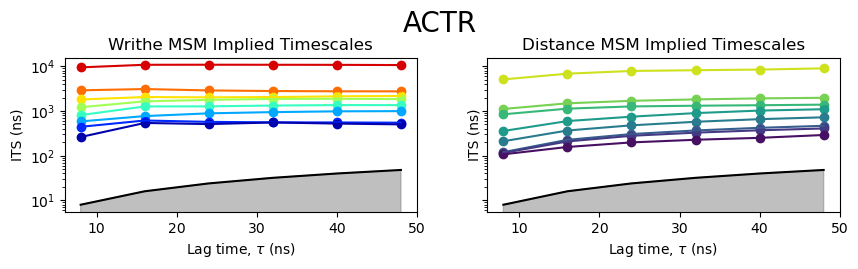

In [12]:
n_its = 8
fig,axes = plt.subplots(1,2, figsize=(10,2), sharey=True)
ax = axes.flat
msm.its("msm", cmap="jet", ax=ax[0], n_its=n_its)
ax[0].set_title("Writhe MSM Implied Timescales")
dist_msm.its("msm", ax=ax[1], n_its=n_its)
ax[1].set_title("Distance MSM Implied Timescales")
fig.suptitle("ACTR", y=1.12, size = 20)

 # Estimate CG Models (if models don't have them)

n_macro = 9
msm, dist_msm = (i.estimate_msm(lag=msm_lag, steps=5).estimate_hmm(n_macro).estimate_pcca(n_macro)
                 for i in (msm, dist_msm))

 # Reindex based on observable and optionally save

reindex_obs = abs(np.concatenate([Writhe.load(writhe_files[i]).writhe_features for i in [0,2,4]],1)).sum(-1)
for i in "hmm,pcca".split(","):
    msm.reindex_msm(i, obs = reindex_obs)
    dist_msm.reindex_msm(i, obs = reindex_obs)
msm.save(msm_dir+"/writhe_msm_long")
dist_msm.save(msm_dir+"/distance_msm_long")

 # Get Indices Lists

In [13]:
dtrajs_pcca = [model.pcca["data"]["dtrajs"][0] for model in (msm, dist_msm)]
writhe_frames_pcca, dist_frames_pcca = map(group_by, dtrajs_pcca)
pops_pcca = [100*count_int_arr(i, norm=True) for i in dtrajs_pcca]

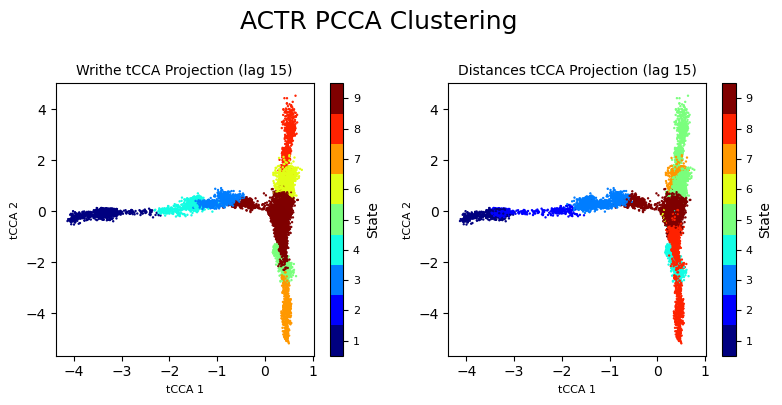

In [15]:
fig,axes=plt.subplots(1,2, sharey=False,figsize=(8,4))

for ax, name, data, color in zip(axes.flat, 
                                 "Writhe,Distances".split(","),
                                 [writhe_tcca, writhe_tcca],
                                 [dtrajs_pcca[0],dtrajs_pcca[1]],
                                 ):
    visualize.proj2d(data, color, ax=ax, state_map=True)
    ax.set_xlabel("tCCA 1", size=8)
    ax.set_ylabel("tCCA 2", size=8)
    ax.set_title(f"{name} tCCA Projection (lag 15)", size=10)
fig.suptitle(protein_name+" PCCA Clustering", fontsize=18, y=1,x=.48)
fig.tight_layout()

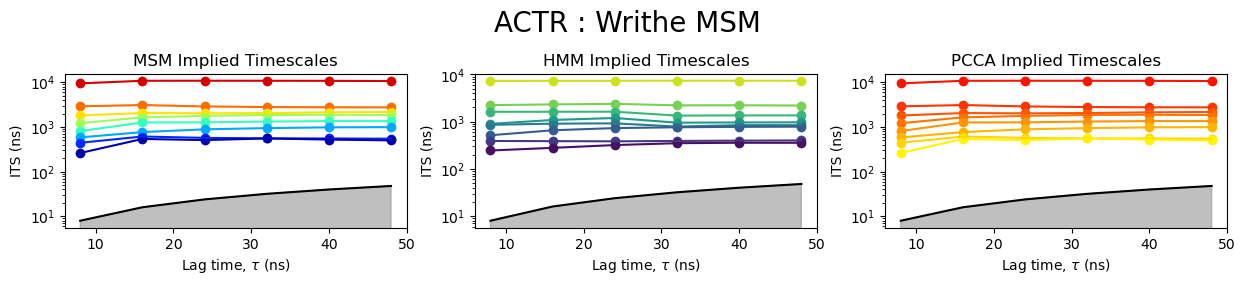

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

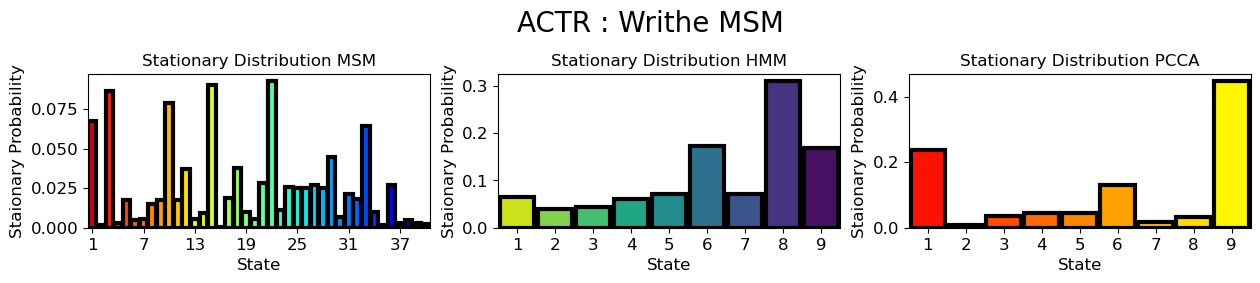

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

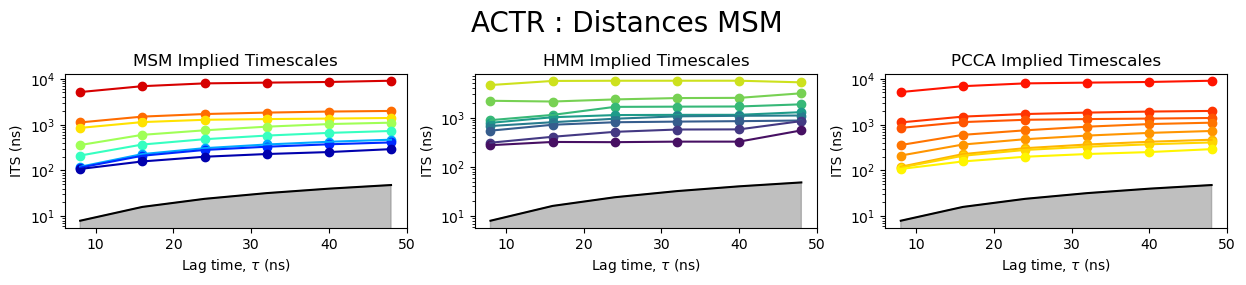

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

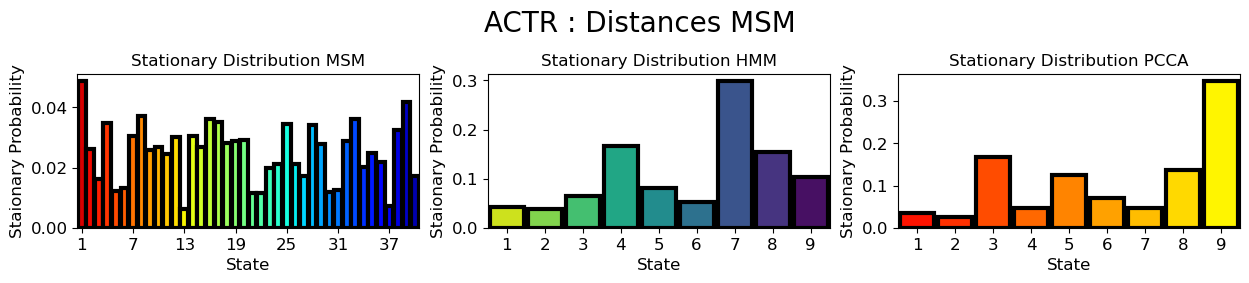

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [522]:
for model_name, m in zip("Writhe,Distances".split(","), [msm, dist_msm]):

    # ITS
    fig, axes = plt.subplots(1,3, figsize=(15,2))
    cmaps = ["jet", "viridis", "autumn_r"]
    for model, ax, cmap in zip("msm,hmm,pcca".split(","), axes.flat, cmaps):
        if model == "msm":
            n_its = 8
        else:
            n_its = None

        plt.figure()
        m.its(model_type= model,
                ax=ax,
                n_its = n_its, 
                cmap=cmap)
    plt.tight_layout()
    fig.suptitle(f"{protein_name} : {model_name} MSM",y=1.2, size=20)


    #Stationary Distributions
    fig, axes = plt.subplots(1,3, figsize=(15,2))
    for model, ax,cmap in zip("msm,hmm,pcca".split(","), axes.flat, cmaps):
        plt.figure()
        if model == "msm":
            state_label_stride = 6
        else:
            state_label_stride = 1
        m.stationary_distribution(model_type= model,
                                    ax=ax,
                                    cmap=cmap,
                                    state_label_stride=state_label_stride)
    plt.tight_layout()
    fig.suptitle(f"{protein_name} : {model_name} MSM",y=1.2, size=20)


In [353]:
from package.writhe.writhe import Writhe

In [354]:
writhe = Writhe(xyz)

In [359]:
writhe.compute_writhe(3, speed_test=True)
print(f"N frames : {len(xyz)}, N residues : {xyz.shape[1]}")

2023-11-26 02:58:36,171	INFO worker.py:1636 -- Started a local Ray instance.


Time elapsed : 10.802862644195557 s
N frames : 29977, N residues : 71


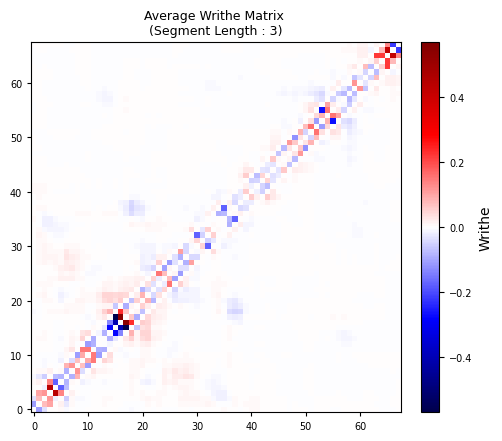

In [356]:
writhe.plot_writhe_matrix()

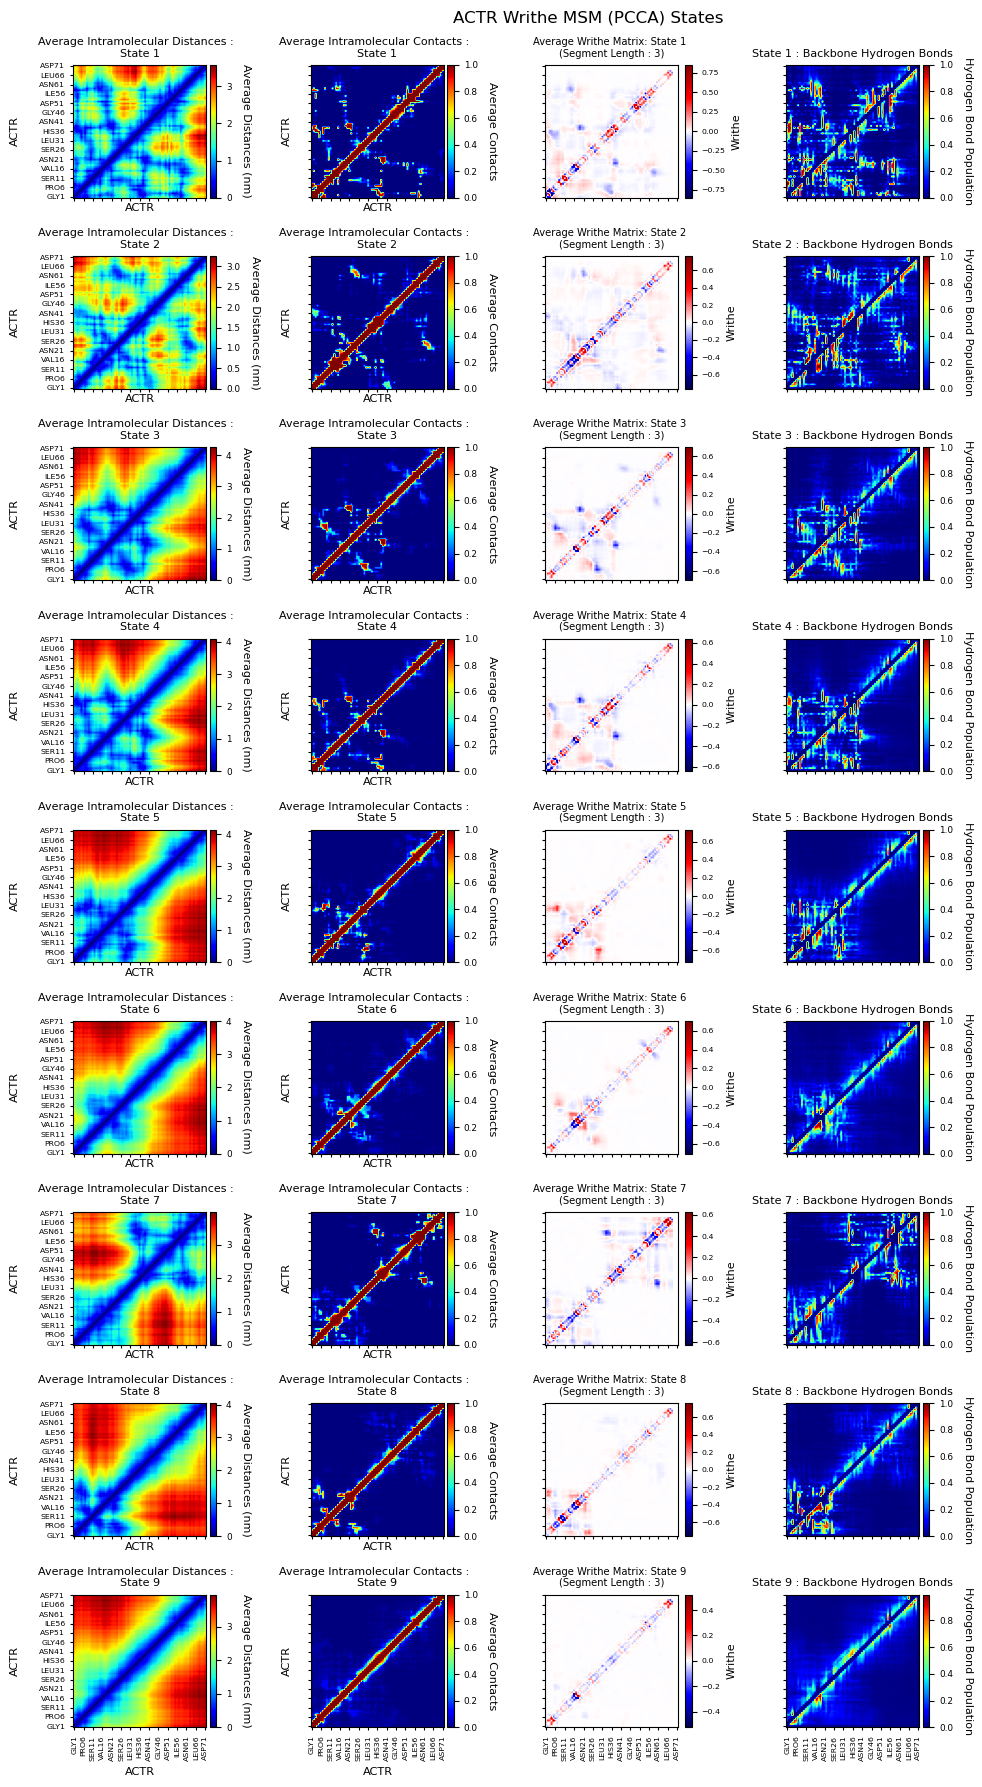

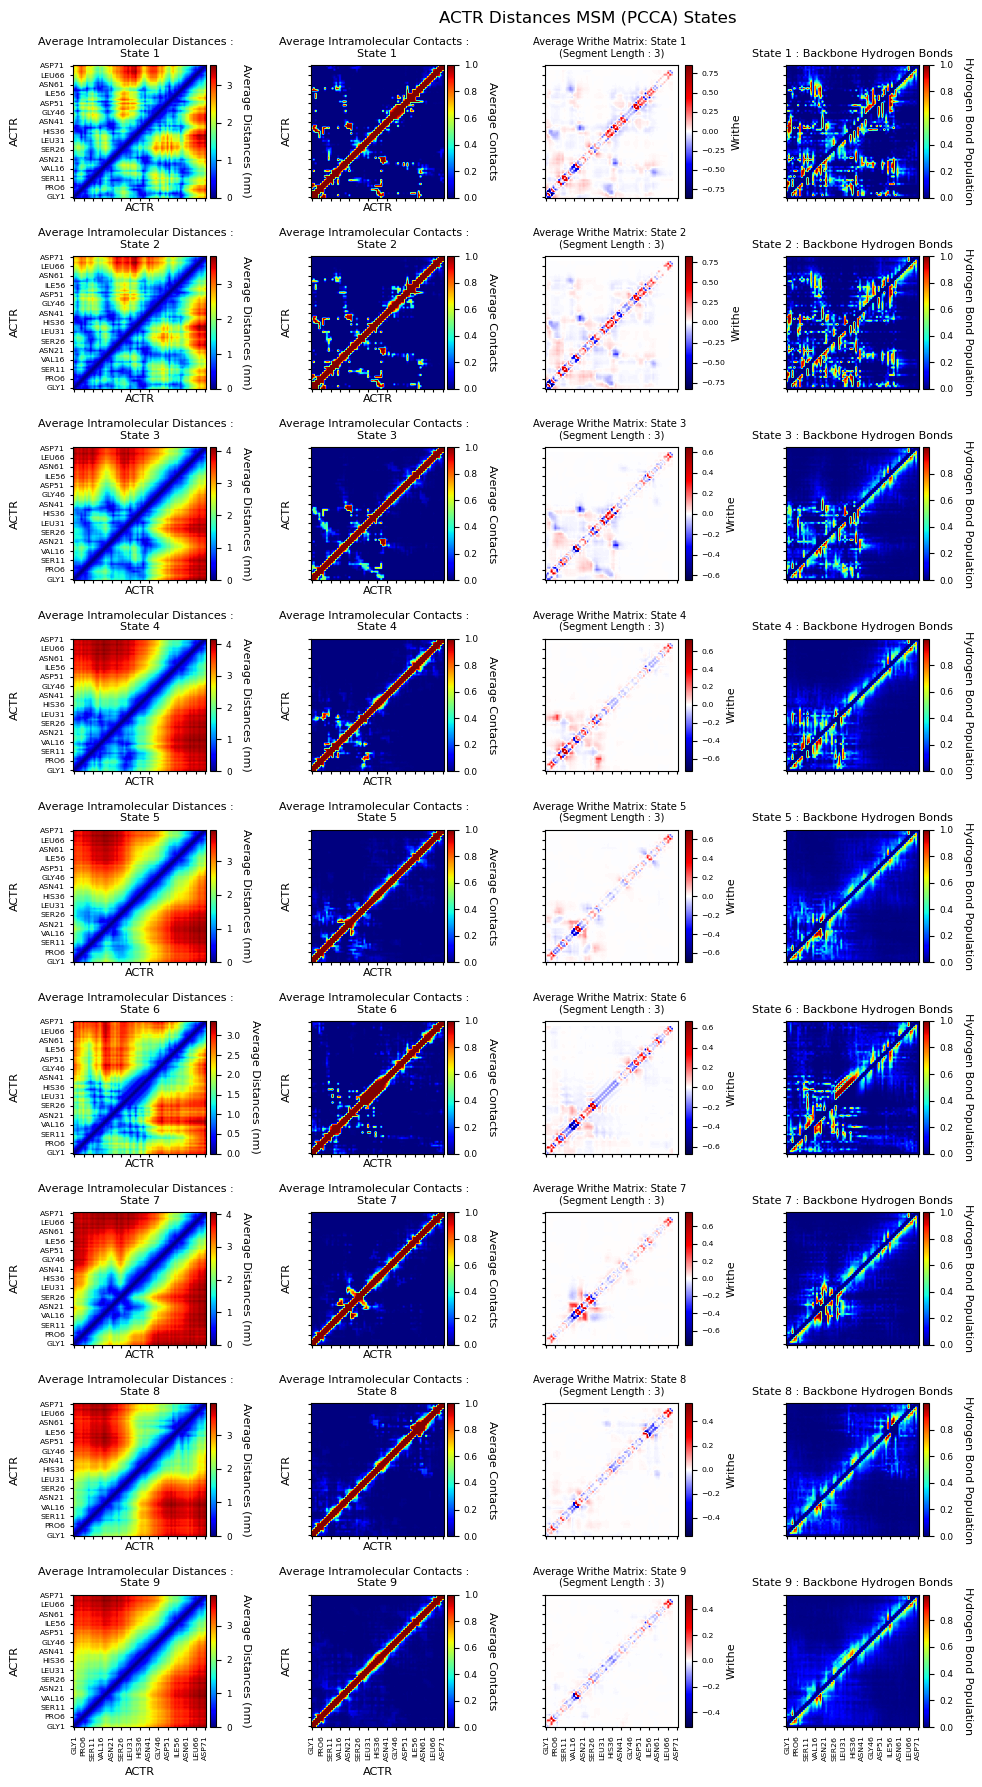

In [524]:
#load writhe class with length 3 data

writhe = Writhe.load(writhe_files[2])

for indices_list, model in zip([writhe_frames_pcca, dist_frames_pcca], "Writhe,Distances".split(",")):
    fig, axes = plt.subplots(9, 4, figsize=(10,18), sharex=True, sharey=True)
    for i, (ax, indices) in enumerate(zip(axes, indices_list)):

        Distances.plot(index=indices, ax=ax[0], label_stride=10,
                      dscr = f" \nState {i+1}", font_scale=.8, )

        Distances.plot(index=indices, ax=ax[1], label_stride=10, contacts=True,
                      dscr = f" \nState {i+1}", font_scale=.8, )    

        writhe.plot_writhe_matrix(index=indices, ax=ax[2], label_stride=10,
                                  dscr = f"State {i+1}", font_scale=.8,
                                  xticks = obs["residues"])

        mdtool.plot_distance_matrix(obs["hbond"][indices].mean(0),
                               title=f"State {i+1} : Backbone Hydrogen Bonds", 
                               xticks=obs["residues"],
                               yticks=obs["residues"],
                               cbar_label="Hydrogen Bond Population", 
                               label_stride=5,
                               ax=ax[3],
                               font_scale=.8,)


    fig.suptitle(f"ACTR {model} MSM (PCCA) States", y = .99,x=.6)
    fig.tight_layout()
    # fig2.tight_layout()

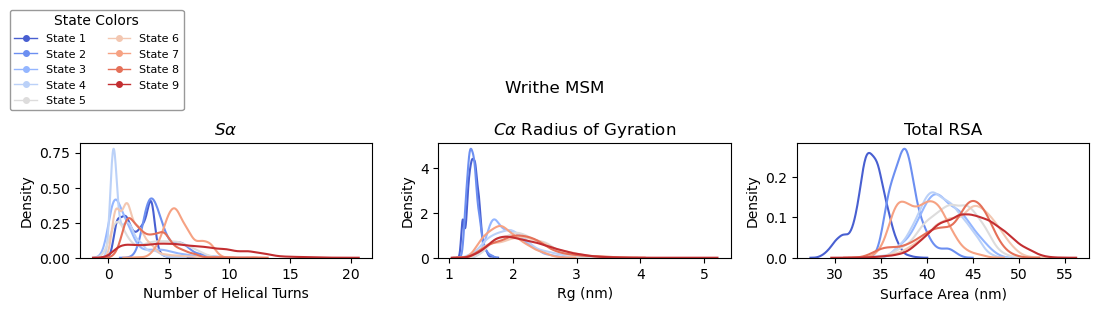

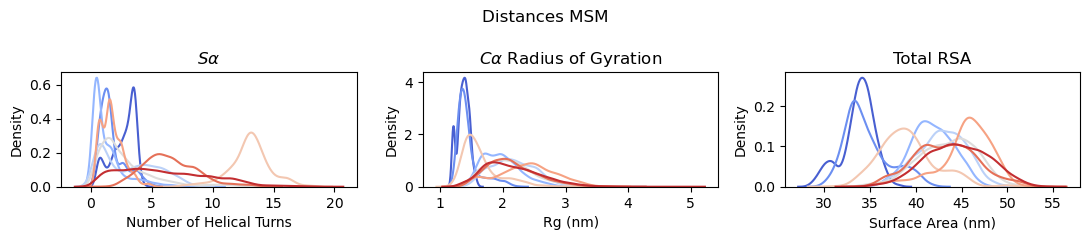

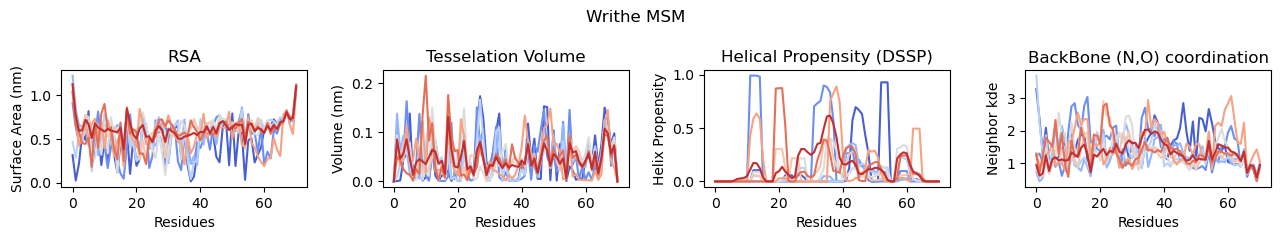

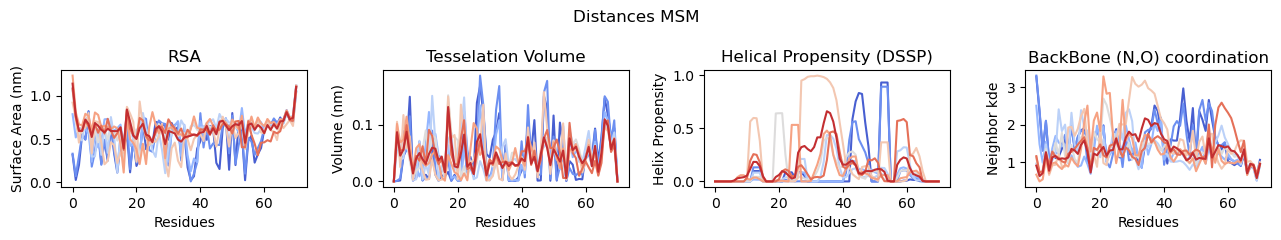

In [525]:
import seaborn as sns
from matplotlib.lines import Line2D


state_colors = color=visualize.get_color_list(n_macro,
                                              "coolwarm",
                                              trunc=10, 
                                              pre_trunc=10,
                                             )

titles = [r"$S\alpha$",
          r"$C\alpha$ Radius of Gyration",
         "Total RSA"]

variables = list(map(obs.__getitem__,
                     "sa_total,rg,rsa_total".split(",")
                    )
                )
xlabels = ["Number of Helical Turns", "Rg (nm)", "Surface Area (nm)"]
count = 0

for indices_list, model in zip([writhe_frames_pcca, dist_frames_pcca], "Writhe,Distances".split(",")): 
    fig, axes = plt.subplots(1,3, figsize=(11,2.4))
    if count==0:
        count+=1
        
        legend_elements = [Line2D([0], [0],
                                  marker="o", 
                                  color=state_colors[i],
                                  label=f"State {i+1}",
                                  markerfacecolor=state_colors[i],
                                  markersize=4,
                                  lw=1)
                           for i in range(len(indices_list))]
        
        fig.legend(handles=legend_elements,title="State Colors",loc="upper left",
                   fontsize=8, title_fontsize=10, edgecolor=(.5,.5,.5), ncol=2,
                  bbox_to_anchor = [0,1.3])
        
        plt.subplots_adjust(top=.75)
        
    for title, xlabel, var, ax in zip(titles, xlabels, variables, axes.flat):
        ax.set_prop_cycle((cycler(color=visualize.get_color_list(n_macro,"coolwarm",
                                                                 trunc=10, 
                                                                 pre_trunc=10,
                                                                ))))
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        for i, indices in enumerate(indices_list):
            sns.kdeplot(var[indices], label=f"State {i+1}", ax=ax)
        
        fig.suptitle(model+" MSM")
        fig.tight_layout()
        
        
titles = ["RSA", 
          "Tesselation Volume",
          "Helical Propensity (DSSP)",
          "BackBone (N,O) coordination"]

variables = list(map(obs.__getitem__,
                     "rsa,norm_vol,dsspH,bb_coord".split(",")
                    )
                )
ylabels = ["Surface Area (nm)", "Volume (nm)", "Helix Propensity", "Neighbor kde" ]

        
for indices_list, model in zip([writhe_frames_pcca, dist_frames_pcca], "Writhe,Distances".split(",")): 
    
    fig, axes = plt.subplots(1,4, figsize=(13,2.4))
    
    for title, ylabel, var, ax in zip(titles, ylabels, variables, axes.flat):
        ax.set_prop_cycle((cycler(color=state_colors)))
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel("Residues")
        for i, indices in enumerate(indices_list):
            ax.plot(var[indices].mean(0), label=f"State {i+1}")
        
    fig.suptitle(model+" MSM")
    fig.tight_layout() 
                                  

                                  


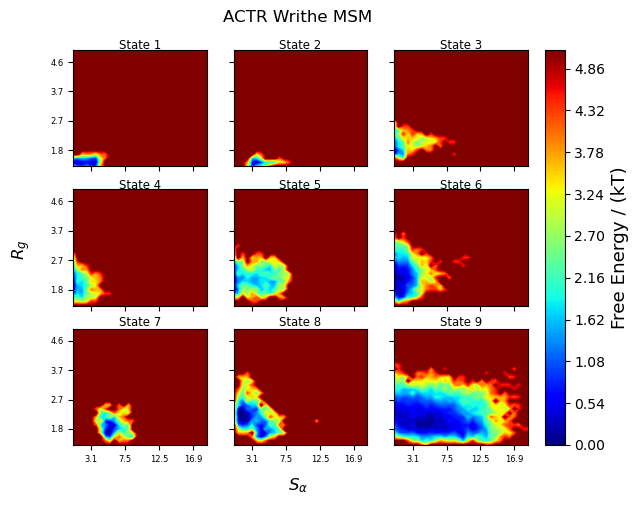

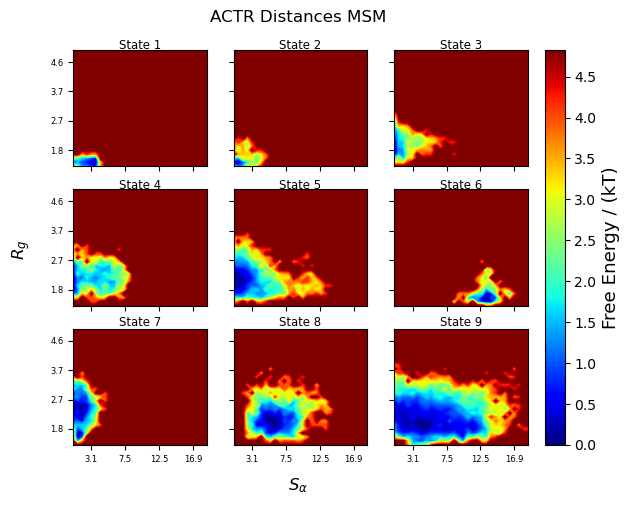

In [425]:
data = np.stack([obs["sa_total"], obs["rg"]], 1)
for indices_list, model in zip([writhe_frames_pcca, dist_frames_pcca], "Writhe,Distances".split(",")): 
    visualize.subplots_fes2d(x=data,
                             rows=3,
                             cols=3,
                             indices_list=indices_list,
                             xlabel=r"$S_{\alpha}$",
                             ylabel=r"$R_{g}$",
                             title = f"ACTR {model} MSM")

In [526]:
dcd = "/home/t/writhe/actr/ACTR-a99SBdisp-Traj.dcd"
pdb = "/home/t/writhe/actr/actr.pdb"
protein_name = "ACTR"
out_dir = "./ACTR"
sele = "protein and (resid 0 to 70)"
trj = md.load(dcd, top=pdb,stride=1).center_coordinates()
trj = trj.atom_slice(trj.topology.select(sele))

 # Find mini ensemble for each state

In [245]:
data = Writhe.load(writhe_files[0]).writhe_features
data = data - data.mean(0)

In [318]:
reload(package.msmtool)
from package.msmtool.msmtool import cov, spd_inv_split, matrix_power, dask_svd

In [274]:
mat = np.load("/home/t/writhe/tCCA_mat_test.npy")

In [278]:
mat.shape

(9580, 9586)

In [298]:
(1.90903377)**(1/2)

1.3816778821418543

In [287]:
out = dask_svd(mat, compressed=True, k = 2, n_chunks=10)

In [294]:
out

[array([[-0.00516527,  0.00056794],
        [ 0.00104982, -0.00372242],
        [ 0.0019009 , -0.00176382],
        ...,
        [ 0.03076595, -0.07893734],
        [ 0.04233983, -0.06223908],
        [ 0.22139359,  0.32334534]]),
 array([1.90903377, 1.863189  ]),
 array([[-0.00109226, -0.00127674,  0.0007992 , ...,  0.01028944,
          0.11798303, -0.13956717],
        [-0.00163866, -0.00305539, -0.00203264, ...,  0.05836672,
         -0.11732879, -0.07926338]])]

In [289]:
import deeptime

In [307]:
vamp = deeptime.decomposition.VAMP(15, 5)
vamp.fit(data[:,:10])

VAMP-140126267873264:dim=5, epsilon=1e-06, lagtime=15,
           observable_transform=<deeptime.basis._monomials.Identity object at 0x7f7231ef1400>,
           scaling=None, var_cutoff=None]

In [316]:
c00, c01, c11 = [getattr(vamp.model, i) for i in "cov_00,cov_0t,cov_tt".split(",")] 

In [323]:
np.allclose(c11, cov(data[:,:10][15:]))

True

In [325]:
dir(vamp.model.cov)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_bessel',
 '_cov_00',
 '_cov_0t',
 '_cov_tt',
 '_data_mean_removed',
 '_lagtime',
 '_mean_0',
 '_mean_t',
 '_symmetrized',
 'bessels_correction',
 'copy',
 'cov_00',
 'cov_0t',
 'cov_tt',
 'data_mean_removed',
 'get_params',
 'lagtime',
 'mean_0',
 'mean_t',
 'set_params',
 'symmetrized',
 'whiten']

In [315]:
dir(vamp.model)

['__abstractmethods__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_cov',
 '_cumvar',
 '_dim',
 '_epsilon',
 '_instantaneous_coefficients',
 '_instantaneous_obs',
 '_instantaneous_whitening_backwards',
 '_koopman_matrix',
 '_output_dimension',
 '_rank_0',
 '_rank_t',
 '_scaling',
 '_singular_values',
 '_timelagged_coefficients',
 '_timelagged_obs',
 '_update_output_dimension',
 '_var_cutoff',
 '_whitening_instantaneous',
 '_whitening_timelagged',
 'backward',
 'ck_test',
 'copy',
 'cov',
 'cov_00',
 'cov_0t',
 'cov_tt',
 'cumulative_kinetic_variance',
 'dim',
 'effective_output_dimension',

In [301]:
vamp.model._koopman_matrix

array([[0.90157636, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.72711871, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33799845, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.25535608, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.25173218,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.16628381, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.15941811, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [306]:
print(vamp._covariance_estimator)

None


In [272]:
np.sum((np.eye(data.shape[1]) - cov(dw))**2)

2.2797721699825773e-07

In [269]:
np.sum((np.eye(data.shape[1]) - cov(dw))**2)

2.246063841217452e-07

In [230]:
!pwd

/home/t/writhe/actr/notebooks


In [233]:
np.load("actr_writhe_feature_set.npy").shape

(29977, 6643)

In [232]:
np.save("actr_writhe_feature_set",
        np.concatenate([Writhe.load(writhe_files[i]).writhe_features for i in [0,2,4]],1))


In [ ]:

# how to order states to give best mini-ensemble
reindex_obs = abs(np.concatenate([Writhe.load(writhe_files[i]).writhe_features for i in [0,2,4]],1)).sum(1)

microstate_indices_lists = [microstate_indices(cg_dtraj, dtraj, sort_obs=reindex_obs, max=True)
                            for cg_dtraj, dtraj in zip(dtrajs_pcca, [msm.dtraj, dist_msm.dtraj])]

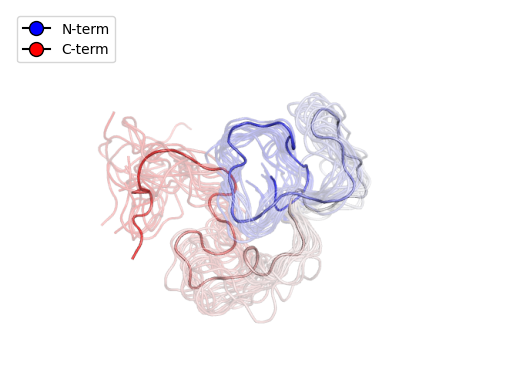

In [740]:
visualize.plot_structure(visualize.make_structures(trj,
                                                   indices=microstate_indices_lists[0][0][10:25],
                                                   dir=os.getcwd(),
                                                   ensemble=True,
                                                   name="test",
                                                   overwrite=True,
                                                   ref=pdb
                                                  ))

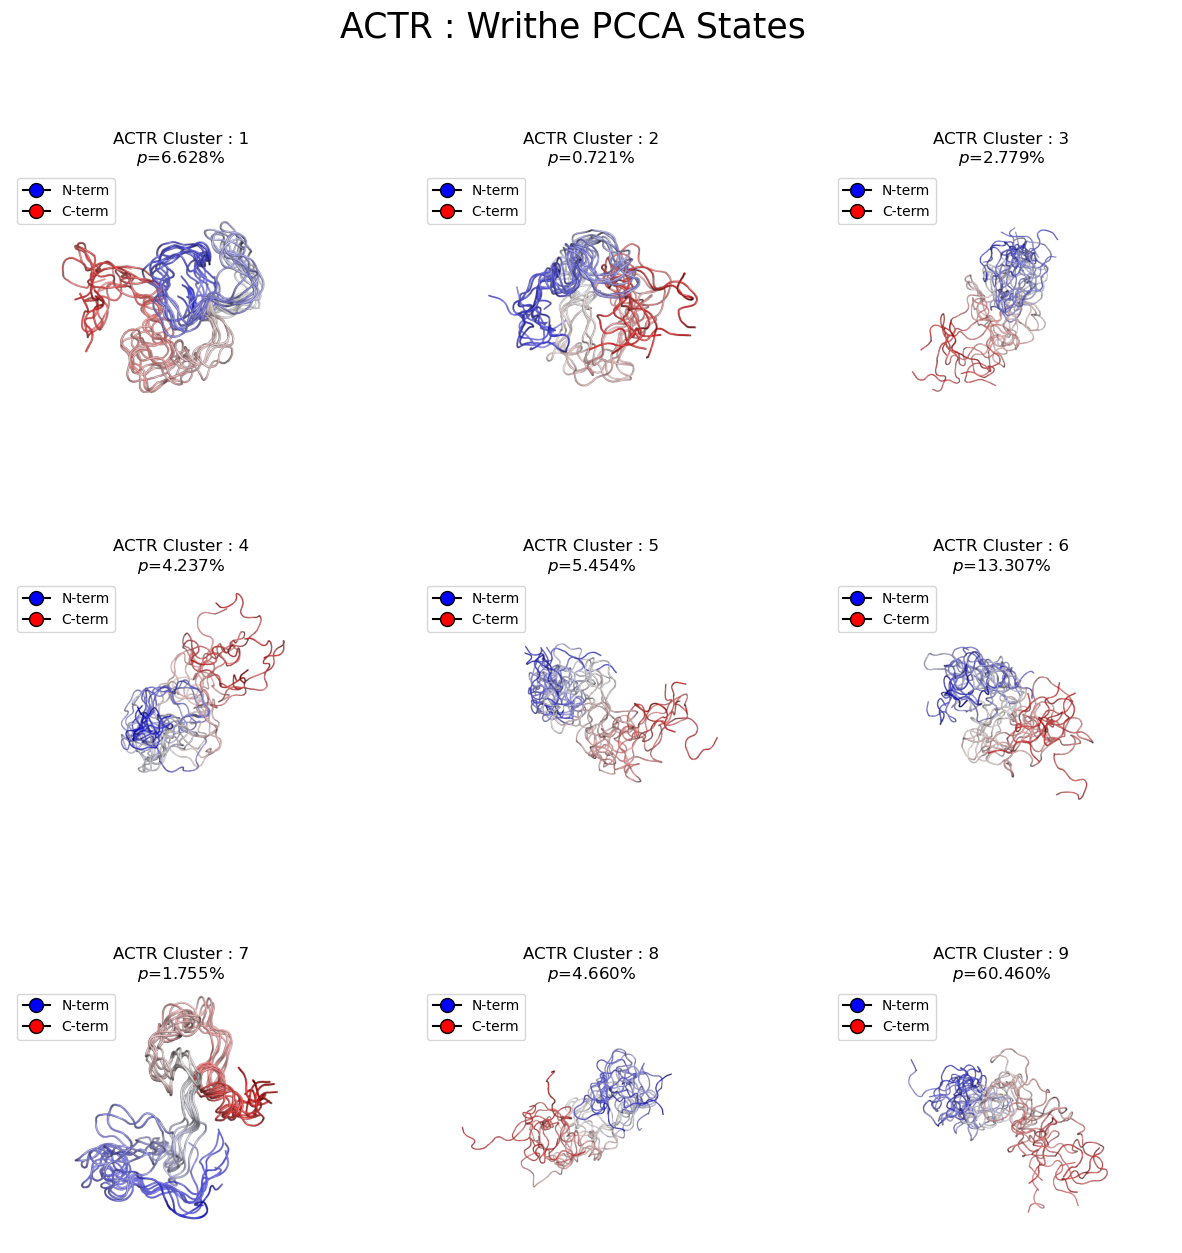

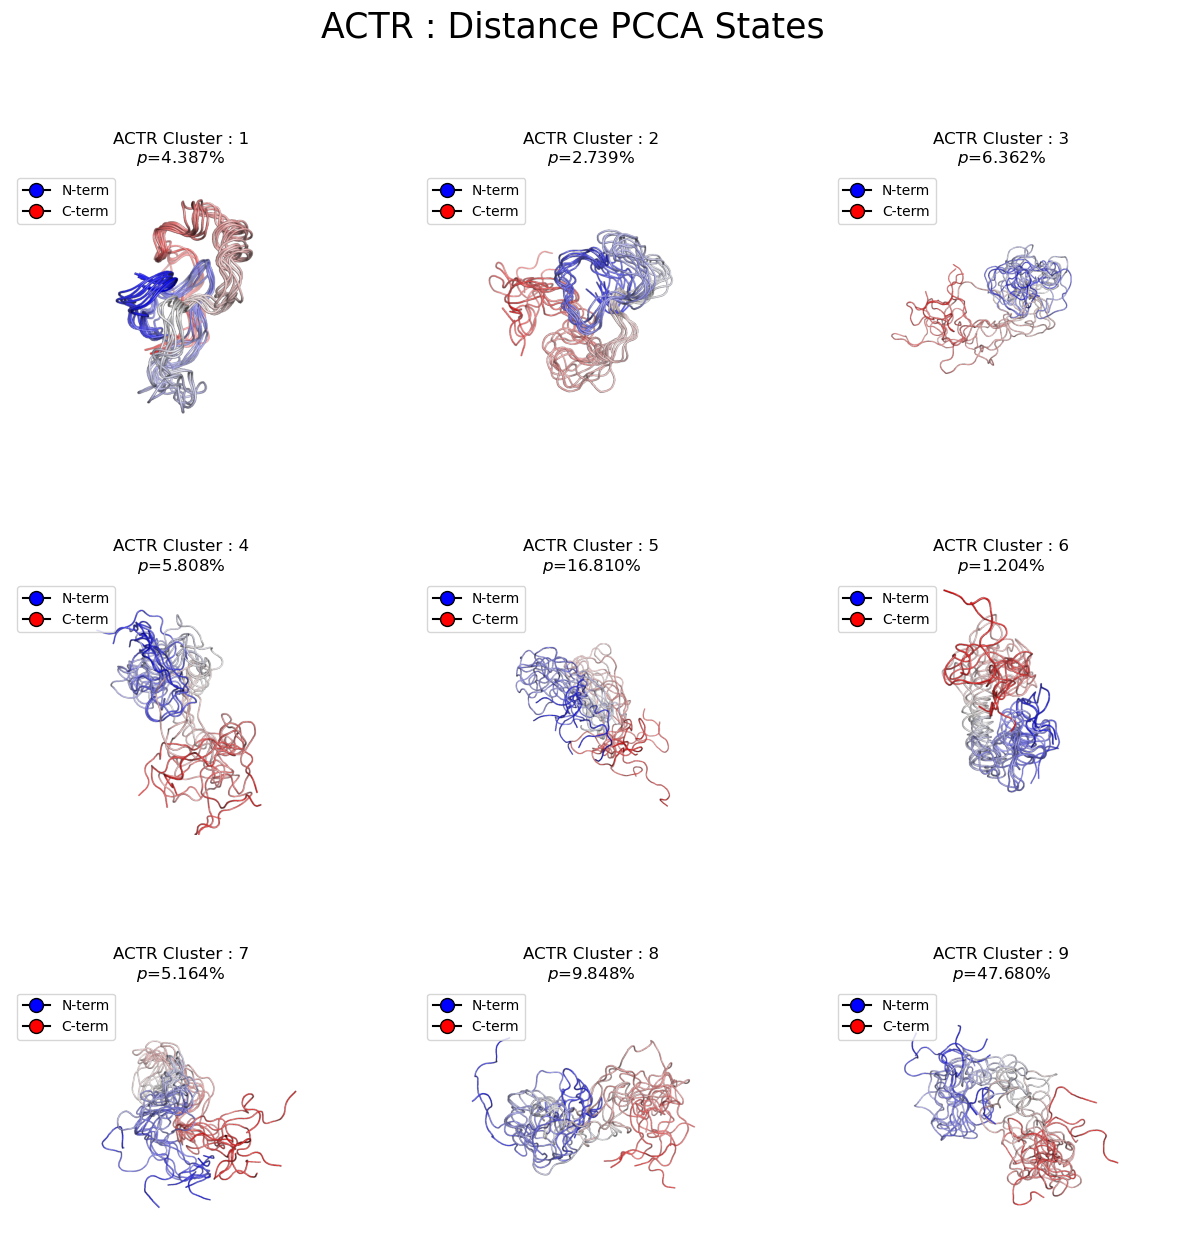

In [746]:
for indices_list, pops, model_type in zip(microstate_indices_lists, pops_pcca, ["Writhe", "Distance"]):
    n_closest = 8
    palette = "blue_gray90_red"
    fig, axes  = plt.subplots(3,3,figsize=(15,15))
    fig.suptitle(f"{protein_name} : {model_type} PCCA States", fontsize=25, y=.96)
    for i, (indices, pop, ax) in enumerate(zip(indices_list, pops, axes.flat)):
        image = visualize.make_structures(trj=trj,
                                          indices=indices[10:n_closest+10],
                                          dir=f"{out_dir}/images",
                                          ensemble=True,
                                          name = f"writhe_pcca_state_{1+i}",
                                          overwrite=True,
                                          transparency=.1,
                                          palette=palette,
                                          ref=pdb)

        visualize.plot_structure(image,
                                 title = (f"{protein_name} Cluster : {i+1}\n"
                                          rf"$p$={pop:.3f}%"),
                                 ax=ax)

In [739]:
import plotly.graph_objects as go
source, target, value = package.msmtool.cluster_similarity(dtrajs_pcca[-1],dtrajs_pcca[0])[-1]
target+=9
import pandas as pd
import plotly.graph_objects as go


fig = go.Figure(data=[go.Sankey(
    node = dict(label = [f"Distance State {i+1}" if i<9 
                      else f"Writhe State {i-8}"
                      for i in range(max(target)+1)],
                #x = list(range(9)),
                y = list(range(9)),),
    link = {"source": source, "target": target, "value": value},
    arrangement='snap',
    )])
fig.update_layout(title_text="Sankey Diagram", font_size=10)
fig.show()

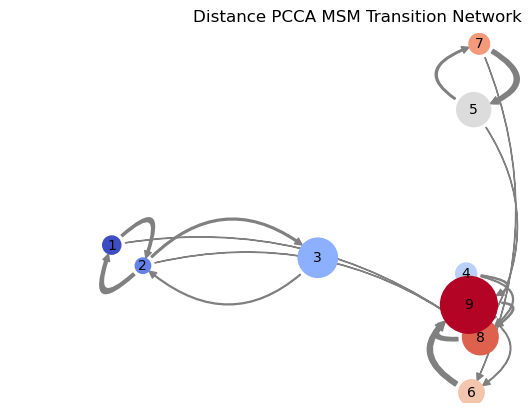

In [19]:
cluster_centers = indices_stat(dist_frames_pcca, distance_tcca[:,:2], axis=0)[0]
#cluster_centers[1] += np.array([0.08, -0.8])
transition_network(dist_msm.pcca["data"]["tmats"][0],
                   dist_msm.pcca["data"]["stat_dists"][0],
                   cluster_centers,
                   title = "Distance PCCA MSM Transition Network",
                   n_edges=16,
                   state_scale = .9,
                   show_labels=False)

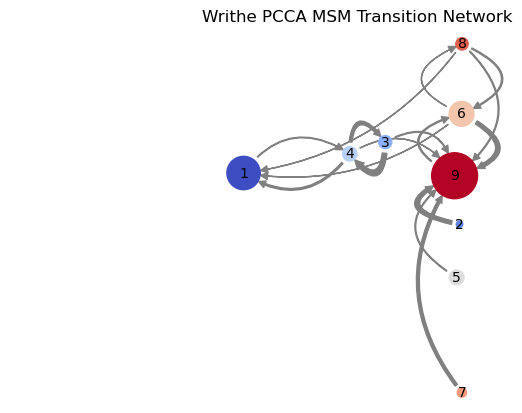

In [898]:
cluster_centers = indices_stat(writhe_frames_pcca, writhe_tcca[:,:2], axis=0)[0]
cluster_centers[1] += np.array([0.08, -0.8])
transition_network(msm.pcca["data"]["tmats"][0],
                   msm.pcca["data"]["stat_dists"][0],
                   cluster_centers,
                   title = "Writhe PCCA MSM Transition Network",
                   n_edges=16,
                   state_scale = 1.5,
                   show_labels=False)